OpenClassrooms
Project 4, Data Scientist
Author : Oumeima EL GHARBI
Date : August 2022

Un notebook pour chaque prédiction (émissions de CO2 et consommation totale d’énergie) des différents tests de modèles mis au propre, dans lequel vous identifierez clairement le modèle final choisi.


L’objectif est de te passer des relevés de consommation annuels futurs (attention à la fuite de données). Nous ferons de toute façon pour tout nouveau bâtiment un premier relevé de référence la première année, donc rien ne t'interdit d’en déduire des variables structurelles aux bâtiments, par exemple la nature et proportions des sources d’énergie utilisées..

Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithmes de ML à l’aide d’une validation croisée.



Tester les modèles suivants : **regression linéaire (avec différentes régularisation : Ridge, Lasso, Elastic), Random Forest, XGboost**
Penser à comparer les performances des différents modèles : utiliser la **MAE** ( Mean Absolute Error)
Penser également à optimiser les hyper paramètres de chaque modèle via **GridSearch**


Evaluate :

https://cloud.google.com/automl-tables/docs/evaluate?hl=fr


KFOLD

Entrée : données X (dimension nxp), étiquettes y (dimension n), nombre de folds k

Couper [0, 1, ..., n-1] en k parties de taille (n/k). (La dernière partie sera un peu plus petite si n n'est pas un multiple de k)

for i=0 to (k-1):
    Former le jeu de test (X_test, y_test) en restreignant X et y aux indices contenus dans la i-ième partie.
    Former le jeu d'entraînement (X_train, y_train) en restreignant X et y aux autres indices.
    Entraîner l'algorithme sur le jeu d'entraînement
    Utiliser le modèle ainsi obtenu pour prédire sur le jeu de test
        Calculer l'erreur du modèle en comparant les étiquettes prédites aux vraies étiquettes contenues dans y_test

Sortie : la valeur moyenne des erreurs calculées sur les k folds.

In [1]:
# 1 modele de Regression (RL classsque / Elastic / ridig / laso
# Random Forest
# XGBOOST

# var à rpedire tottal GHE Emssion last one to predict
# cette var deped de la consommation des bateimenst (1) prediction sur elec, steam, naturalgas et un autre energie (2) et reutiliser pour predire

### Introduction

#### Importing libraries

In [2]:
%reset -f

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%autosave 300

Autosaving every 300 seconds


#### Loading dataset

In [3]:
columns_to_categorize = ["BuildingType", "PrimaryPropertyType", "ZipCode", "CouncilDistrictCode", "LargestPropertyUseType", "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType"]
#  "Neighborhood",
category_types = {column: 'category' for column in columns_to_categorize}
print("This dictionary will be used when reading the csv file to assign a type to categorical features :", category_types)

This dictionary will be used when reading the csv file to assign a type to categorical features : {'BuildingType': 'category', 'PrimaryPropertyType': 'category', 'ZipCode': 'category', 'CouncilDistrictCode': 'category', 'LargestPropertyUseType': 'category', 'SecondLargestPropertyUseType': 'category', 'ThirdLargestPropertyUseType': 'category'}


In [4]:
dataset_path = "dataset/cleaned/2016_Building_Energy_Prediction.csv"
# we assign the categorical features with a categotical type
data = pd.read_csv(dataset_path, dtype=category_types, sep=",")

In [5]:
data.shape

(3131, 29)

In [6]:
data.dtypes

OSEBuildingID                         int64
BuildingType                       category
PrimaryPropertyType                category
ZipCode                            category
CouncilDistrictCode                category
Neighborhood                         object
YearBuilt                             int64
NumberofBuildings                   float64
NumberofFloors                        int64
PropertyGFATotal                      int64
PropertyGFAParking                    int64
PropertyGFABuilding(s)                int64
LargestPropertyUseType             category
LargestPropertyUseTypeGFA           float64
SecondLargestPropertyUseType       category
SecondLargestPropertyUseTypeGFA     float64
ThirdLargestPropertyUseType        category
ThirdLargestPropertyUseTypeGFA      float64
ENERGYSTARScore                     float64
SiteEnergyUse(kBtu)                 float64
SteamUse(kBtu)                      float64
Electricity(kBtu)                   float64
NaturalGas(kBtu)                

In [7]:
# predict : Electricity
# train / test
# standardisation = retirer la moyen et div par ecart type (scaling : les var qn sur emem echelle
# var categ : encoding (one hot encoder)

# la fin Feature engineriing

# 2) entrainer le smodels
# perf
# temps de calcul
# graph pour montrer la perf de chaque modele(barplot)
# obj : finir exploration / finir feature engineering
# obj un premier noteboook propre (try max)

In [8]:
data.columns

Index(['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'ZipCode',
       'CouncilDistrictCode', 'Neighborhood', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore',
       'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'TotalGHGEmissions', 'Log2-SiteEnergyUse(kBtu)',
       'Log2-SteamUse(kBtu)', 'Log2-Electricity(kBtu)',
       'Log2-NaturalGas(kBtu)', 'Log2-TotalGHGEmissions'],
      dtype='object')

In [9]:
features_for_prediction = ["YearBuilt",  "BuildingType","PrimaryPropertyType", "Neighborhood", "NumberofFloors", "PropertyGFATotal", "PropertyGFAParking", "SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseTypeGFA"]

variable_to_predict = "Log2-Electricity(kBtu)"

features_for_prediction.append(variable_to_predict)
print(features_for_prediction)


['YearBuilt', 'BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'Log2-Electricity(kBtu)']


In [10]:
data = data[features_for_prediction]

data

,YearBuilt,BuildingType,PrimaryPropertyType,Neighborhood,NumberofFloors,PropertyGFATotal,PropertyGFAParking,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,Log2-Electricity(kBtu)
0,1978,Multifamily LR (1-4),Low-Rise Multifamily,central,3,20739,0,0.0,0.0,19.638743
1,1928,NonResidential,Warehouse,greater duwamish,2,25955,0,8745.0,3060.0,20.216217
2,1925,Multifamily LR (1-4),Low-Rise Multifamily,greater duwamish,3,25120,0,0.0,0.0,18.213921
3,1971,Multifamily HR (10+),High-Rise Multifamily,greater duwamish,15,73898,0,0.0,0.0,21.038823
4,2001,Multifamily LR (1-4),Low-Rise Multifamily,greater duwamish,3,36383,7030,4200.0,0.0,19.327996
...,...,...,...,...,...,...,...,...,...,...
3126,2001,NonResidential,Mixed Use Property,lake union,3,41827,9226,14128.0,9680.0,21.217915
3127,1907,Multifamily LR (1-4),Low-Rise Multifamily,lake union,4,36660,0,0.0,0.0,18.981534
3128,2001,NonResidential,Small- and Mid-Sized Office,lake union,5,33740,6010,8762.0,1500.0,20.300511
3129,1911,NonResidential,Retail Store,lake union,2,20516,0,8000.0,0.0,18.015551


## I) Feature Engineering : preparing the vectors and matrices


#### 1) Separating training data and target vector

In [11]:
# we create the data matrix / we only take the features
X = data[data.columns[:-1]]

# we create the target vector
y = data[variable_to_predict].values # numpy array not a DataFrame anymore

print("Shape of X :", X.shape)
print("Shape of y :", y.shape)

Shape of X : (3131, 9)
Shape of y : (3131,)


In [12]:
X

,YearBuilt,BuildingType,PrimaryPropertyType,Neighborhood,NumberofFloors,PropertyGFATotal,PropertyGFAParking,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA
0,1978,Multifamily LR (1-4),Low-Rise Multifamily,central,3,20739,0,0.0,0.0
1,1928,NonResidential,Warehouse,greater duwamish,2,25955,0,8745.0,3060.0
2,1925,Multifamily LR (1-4),Low-Rise Multifamily,greater duwamish,3,25120,0,0.0,0.0
3,1971,Multifamily HR (10+),High-Rise Multifamily,greater duwamish,15,73898,0,0.0,0.0
4,2001,Multifamily LR (1-4),Low-Rise Multifamily,greater duwamish,3,36383,7030,4200.0,0.0
...,...,...,...,...,...,...,...,...,...
3126,2001,NonResidential,Mixed Use Property,lake union,3,41827,9226,14128.0,9680.0
3127,1907,Multifamily LR (1-4),Low-Rise Multifamily,lake union,4,36660,0,0.0,0.0
3128,2001,NonResidential,Small- and Mid-Sized Office,lake union,5,33740,6010,8762.0,1500.0
3129,1911,NonResidential,Retail Store,lake union,2,20516,0,8000.0,0.0


#### 2) Separation train and test dataset


In [13]:
print("We have to separate the train / test sets before normalising the dataset.")

We have to separate the train / test sets before normalising the dataset.


In [14]:
# We create a training set and a test set (the test set contains 30% of the dataset)
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,  random_state=42)

In [15]:
X_train.shape

(2191, 9)

In [16]:
X_test.shape

(940, 9)

#### 3) Normalization

In [17]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

In [18]:
print("We separate categorical variables from numerical variables.")

We separate categorical variables from numerical variables.


In [19]:
X.select_dtypes(['category','object']) # we don't have 'object' here but it is just in case.

categorical_columns = X.select_dtypes(['category','object']).columns
numerical_columns = X.select_dtypes(include='number').columns.drop("YearBuilt")
print("We won't normalise the year so we drop it from numerical_columns.")

print("Shape of categorical variables : ", categorical_columns.shape)
print("Shape of numerical variables :", numerical_columns.shape)

We won't normalise the year so we drop it from numerical_columns.
Shape of categorical variables :  (3,)
Shape of numerical variables : (5,)


##### 1) Data Standardisation

We have to standardize the variables before learning a **Ridge Regression**.
Standardizing means that each variable will have a **standard deviation** equal to 1.

In [20]:
print("Numerical variables standardization")
print("We have :", numerical_columns.shape[0], "numerical features to standardize.",end="\n\n")

print(numerical_columns)

Numerical variables standardization
We have : 5 numerical features to standardize.

Index(['NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA'],
      dtype='object')


In [21]:
# We train / fit the scaler on the training set / Computes the mean and std to be used for later scaling.
std_scale = StandardScaler().fit(X_train[numerical_columns])
# We transform the training set and the testing set / Performs standardization by centering and scaling.
X_train_std = X_train.copy()
X_test_std = X_test.copy()

X_train_std[numerical_columns] = std_scale.transform(X_train[numerical_columns])
X_test_std[numerical_columns] = std_scale.transform(X_test[numerical_columns])

print("Before")
display(X_train)
print("After")
display(X_train_std)

Before


,YearBuilt,BuildingType,PrimaryPropertyType,Neighborhood,NumberofFloors,PropertyGFATotal,PropertyGFAParking,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA
2091,1922,NonResidential,Hotel,downtown,11,92190,25200,25200.0,0.0
2071,1930,NonResidential,Hotel,downtown,20,98634,10043,10043.0,5000.0
964,1929,Nonresidential COS,Other,northeast,3,27908,0,0.0,0.0
2218,1970,NonResidential,Small- and Mid-Sized Office,lake union,7,94002,0,31348.0,0.0
2737,1929,Multifamily LR (1-4),Low-Rise Multifamily,magnolia / queen anne,3,32908,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
3092,1986,NonResidential,Small- and Mid-Sized Office,magnolia / queen anne,3,40067,0,0.0,0.0
1095,2012,Multifamily MR (5-9),Mid-Rise Multifamily,northeast,7,74421,0,0.0,0.0
1130,2014,Multifamily MR (5-9),Mid-Rise Multifamily,ballard,8,439262,0,181729.0,16415.0
1294,1998,Multifamily MR (5-9),Mid-Rise Multifamily,east,5,33274,0,12344.0,0.0


After


,YearBuilt,BuildingType,PrimaryPropertyType,Neighborhood,NumberofFloors,PropertyGFATotal,PropertyGFAParking,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA
2091,1922,NonResidential,Hotel,downtown,1.165681,0.028850,0.499697,0.311646,-0.207072
2071,1930,NonResidential,Hotel,downtown,2.831097,0.076627,0.047235,-0.105775,0.350267
964,1929,Nonresidential COS,Other,northeast,-0.314688,-0.447747,-0.252566,-0.382358,-0.207072
2218,1970,NonResidential,Small- and Mid-Sized Office,lake union,0.425496,0.042285,-0.252566,0.480961,-0.207072
2737,1929,Multifamily LR (1-4),Low-Rise Multifamily,magnolia / queen anne,-0.314688,-0.410676,-0.252566,-0.382358,-0.207072
...,...,...,...,...,...,...,...,...,...
3092,1986,NonResidential,Small- and Mid-Sized Office,magnolia / queen anne,-0.314688,-0.357598,-0.252566,-0.382358,-0.207072
1095,2012,Multifamily MR (5-9),Mid-Rise Multifamily,northeast,0.425496,-0.102892,-0.252566,-0.382358,-0.207072
1130,2014,Multifamily MR (5-9),Mid-Rise Multifamily,ballard,0.610543,2.602097,-0.252566,4.622429,1.622672
1294,1998,Multifamily MR (5-9),Mid-Rise Multifamily,east,0.055404,-0.407962,-0.252566,-0.042406,-0.207072


We can check that the numerical variables have a Standard Normal distribution.


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdep

IMPORT FUNCTIONS / DENSITE


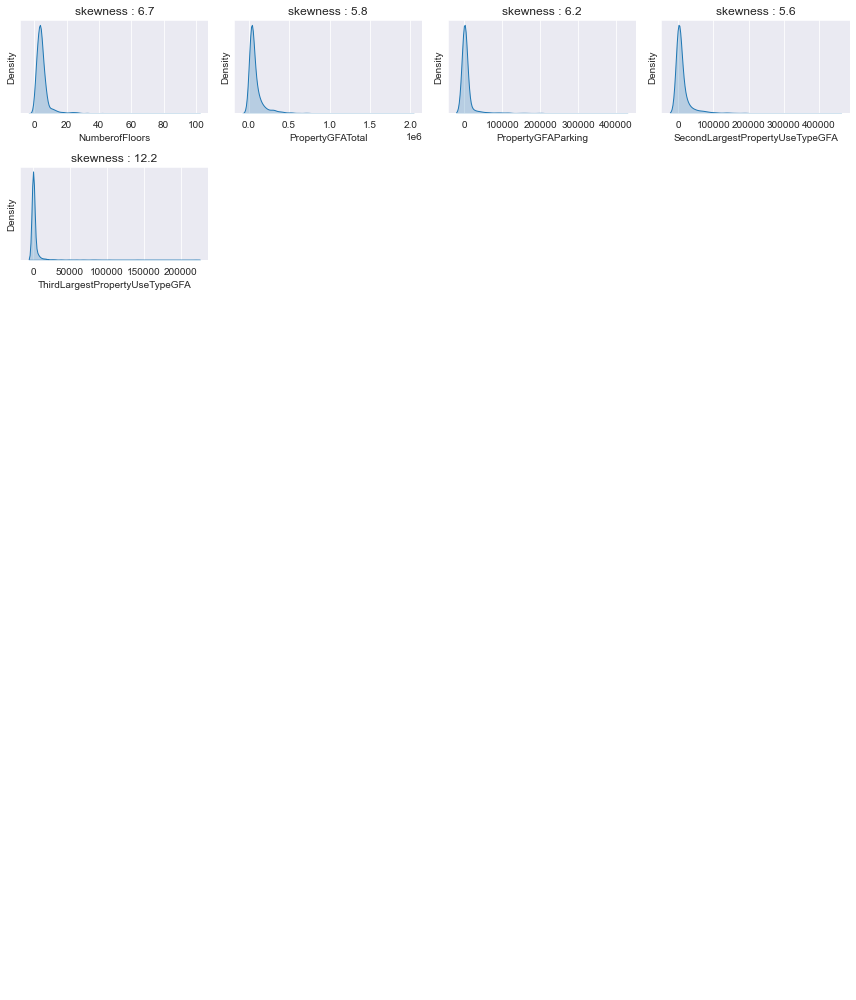

In [22]:
def densite(df, lines=7, cols=4):
    """
    Input : dataframe, lignes, colonnes
    Output : grille des courbes de densités des variables numériques du dataframe
    """
    df = df.select_dtypes(include='number').copy()

    fig, ax = plt.subplots(lines, cols, figsize=(min(15, cols * 3), lines * 2))

    for i, val in enumerate(df.columns.tolist()):
        bp = sns.distplot(df[val], hist=False, ax=ax[i // cols, i % cols], kde_kws={'shade': True})
        bp.set_title("skewness : " + str(round(df[val].skew(), 1)), fontsize=12)
        bp.set_yticks([])
        imax = i

    for i in range(imax + 1, lines * cols):
        ax[i // cols, i % cols].axis('off')

    plt.tight_layout()

print("We can check that the numerical variables have a Standard Normal distribution.")
densite(X_train[numerical_columns])

print("IMPORT FUNCTIONS / DENSITE")

##### 2) Feature Encoding : One Hot Encoder

In [23]:
print("Categorical variables featuring")

print("We have :", categorical_columns.shape[0], "categorical features to encode.", end="\n\n")
print(categorical_columns)

Categorical variables featuring
We have : 3 categorical features to encode.

Index(['BuildingType', 'PrimaryPropertyType', 'Neighborhood'], dtype='object')


In [24]:
X.dtypes # we check that we have categories

YearBuilt                             int64
BuildingType                       category
PrimaryPropertyType                category
Neighborhood                         object
NumberofFloors                        int64
PropertyGFATotal                      int64
PropertyGFAParking                    int64
SecondLargestPropertyUseTypeGFA     float64
ThirdLargestPropertyUseTypeGFA      float64
dtype: object

In [25]:
X[categorical_columns].nunique()

BuildingType            8
PrimaryPropertyType    23
Neighborhood           13
dtype: int64

In [26]:
X_train_std[categorical_columns]

,BuildingType,PrimaryPropertyType,Neighborhood
2091,NonResidential,Hotel,downtown
2071,NonResidential,Hotel,downtown
964,Nonresidential COS,Other,northeast
2218,NonResidential,Small- and Mid-Sized Office,lake union
2737,Multifamily LR (1-4),Low-Rise Multifamily,magnolia / queen anne
...,...,...,...
3092,NonResidential,Small- and Mid-Sized Office,magnolia / queen anne
1095,Multifamily MR (5-9),Mid-Rise Multifamily,northeast
1130,Multifamily MR (5-9),Mid-Rise Multifamily,ballard
1294,Multifamily MR (5-9),Mid-Rise Multifamily,east


##### Encoding the categorical features of the train set


In [27]:
print("Now, we can use the One Hot Encoder.")
print("With the one hot encoder, we will get :", sum([X[categorical_columns].nunique()[i] for i in range(len(categorical_columns))]), "columns to encodes the categorical features.")

Now, we can use the One Hot Encoder.
With the one hot encoder, we will get : 44 columns to encodes the categorical features.


In [28]:
# 0) creating instance of one-hot-encoder
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False) # if sparse=True (by default), we need to add .toarray() to encoded_categorical_data

# 1) Fit the encoder on the training set
one_hot_encoder.fit(X_train_std[categorical_columns])

# 2) we get the encoded numpy array
encoded_categorical_data = one_hot_encoder.transform(X_train_std[categorical_columns])

# 3) we make a list of the columns names
encoded_categorical_data_names = one_hot_encoder.get_feature_names_out().tolist()
print("We have indeed :", len(encoded_categorical_data_names), "labels after encoding the categorical variables.")

# 4) we recreate a dataframe with the column names and the numpy array
X_train_encoded = pd.DataFrame(columns=encoded_categorical_data_names,
                               data=encoded_categorical_data,
                               index=X_train_std.index)
display(X_train_encoded.sort_index())

We have indeed : 44 labels after encoding the categorical variables.


,BuildingType_Campus,BuildingType_Multifamily HR (10+),BuildingType_Multifamily LR (1-4),BuildingType_Multifamily MR (5-9),BuildingType_NonResidential,BuildingType_Nonresidential COS,BuildingType_Nonresidential WA,BuildingType_SPS-District K-12,PrimaryPropertyType_Distribution Center,PrimaryPropertyType_High-Rise Multifamily,...,Neighborhood_downtown,Neighborhood_east,Neighborhood_greater duwamish,Neighborhood_lake union,Neighborhood_magnolia / queen anne,Neighborhood_north,Neighborhood_northeast,Neighborhood_northwest,Neighborhood_southeast,Neighborhood_southwest
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3125,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3126,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3128,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# 5) Concatenate the two dataframes for the training set

print("We need to add YearBuilt to the list of features.")
numerical_columns.tolist()
features_to_merge = numerical_columns.tolist().copy()
features_to_merge.append("YearBuilt")
print(features_to_merge, end="\n\n")

print("ASK JEREMY : merge based on index ok ? or should I put back OSEBuildingID ??")
X_train_std_encoded = pd.merge(X_train_std[features_to_merge].sort_index(), X_train_encoded.sort_index(), left_index=True, right_index=True)
display(X_train_std_encoded.sort_index())

We need to add YearBuilt to the list of features.
['NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'YearBuilt']

ASK JEREMY : merge based on index ok ? or should I put back OSEBuildingID ??


,NumberofFloors,PropertyGFATotal,PropertyGFAParking,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,YearBuilt,BuildingType_Campus,BuildingType_Multifamily HR (10+),BuildingType_Multifamily LR (1-4),BuildingType_Multifamily MR (5-9),...,Neighborhood_downtown,Neighborhood_east,Neighborhood_greater duwamish,Neighborhood_lake union,Neighborhood_magnolia / queen anne,Neighborhood_north,Neighborhood_northeast,Neighborhood_northwest,Neighborhood_southeast,Neighborhood_southwest
1,-0.499734,-0.462226,-0.252566,-0.141522,0.134019,1928,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.314688,-0.468417,-0.252566,-0.382358,-0.207072,1925,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.905866,-0.106769,-0.252566,-0.382358,-0.207072,1971,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.314688,-0.384912,-0.042709,-0.266691,-0.207072,2001,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-0.129642,-0.365813,-0.252566,-0.382358,-0.207072,1996,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,0.055404,-0.264528,-0.252566,-0.382358,-0.207072,1925,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3125,-0.499734,-0.403766,-0.252566,-0.006164,-0.046558,1927,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3126,-0.314688,-0.344549,0.022846,0.006725,0.871936,2001,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3128,0.055404,-0.404507,-0.073157,-0.141054,-0.039870,2001,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Encoding the categorical features of the test set

In [30]:
# 5) One Hot Encoding on the testing set

# 5.1) we get the encoded numpy array
TEST_encoded_categorical_data = one_hot_encoder.transform(X_test_std[categorical_columns])

print("ASK JEREMY for this method below ???")
# 5.2) we recreate a dataframe with the column names and the numpy array
X_test_encoded = pd.DataFrame(columns=encoded_categorical_data_names,
                               data=TEST_encoded_categorical_data,
                               index=X_test_std.index)
display(X_test_encoded.sort_index())

print("ASK JEREMY : merge based on index ok ? or should I put back OSEBuildingID ??")
X_test_std_encoded = pd.merge(X_test_std[features_to_merge].sort_index(), X_test_encoded.sort_index(), left_index=True, right_index=True)
display(X_test_std_encoded.sort_index())

ASK JEREMY for this method below ???


,BuildingType_Campus,BuildingType_Multifamily HR (10+),BuildingType_Multifamily LR (1-4),BuildingType_Multifamily MR (5-9),BuildingType_NonResidential,BuildingType_Nonresidential COS,BuildingType_Nonresidential WA,BuildingType_SPS-District K-12,PrimaryPropertyType_Distribution Center,PrimaryPropertyType_High-Rise Multifamily,...,Neighborhood_downtown,Neighborhood_east,Neighborhood_greater duwamish,Neighborhood_lake union,Neighborhood_magnolia / queen anne,Neighborhood_north,Neighborhood_northeast,Neighborhood_northwest,Neighborhood_southeast,Neighborhood_southwest
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3118,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3121,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3127,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


ASK JEREMY : merge based on index ok ? or should I put back OSEBuildingID ??


,NumberofFloors,PropertyGFATotal,PropertyGFAParking,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,YearBuilt,BuildingType_Campus,BuildingType_Multifamily HR (10+),BuildingType_Multifamily LR (1-4),BuildingType_Multifamily MR (5-9),...,Neighborhood_downtown,Neighborhood_east,Neighborhood_greater duwamish,Neighborhood_lake union,Neighborhood_magnolia / queen anne,Neighborhood_north,Neighborhood_northeast,Neighborhood_northwest,Neighborhood_southeast,Neighborhood_southwest
0,-0.314688,-0.500899,-0.252566,-0.382358,-0.207072,1978,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-0.314688,0.240235,-0.252566,0.043078,-0.207072,1977,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12,-0.499734,-0.299056,0.385783,-0.217119,-0.207072,1991,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,-0.129642,0.514730,-0.252566,0.201569,0.245487,2010,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,-0.684781,-0.427565,-0.252566,-0.315106,-0.207072,1980,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116,0.240450,0.064364,-0.252566,-0.382358,-0.207072,2007,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3118,0.055404,-0.413997,-0.252566,-0.382358,-0.207072,1915,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3121,-0.129642,-0.359874,-0.252566,-0.382358,-0.207072,1925,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3127,-0.129642,-0.382858,-0.252566,-0.382358,-0.207072,1907,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# Save
X_train_std_encoded.to_csv("dataset/cleaned/electricity/X_train.csv", index=False)
X_test_std_encoded.to_csv("dataset/cleaned/electricity/X_test.csv", index=False)
y_train.to_csv("dataset/cleaned/electricity/y_train.csv", index=False)
y_test.to_csv("dataset/cleaned/electricity/y_test.csv", index=False)

## II) Modelisation

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [32]:
print("We can start now the modelling to predict the feature wanted.")

display(X_train_std_encoded)
display(X_test_std_encoded)
print(y_train.shape, y_test.shape)

We can start now the modelling to predict the feature wanted.


,NumberofFloors,PropertyGFATotal,PropertyGFAParking,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,YearBuilt,BuildingType_Campus,BuildingType_Multifamily HR (10+),BuildingType_Multifamily LR (1-4),BuildingType_Multifamily MR (5-9),...,Neighborhood_downtown,Neighborhood_east,Neighborhood_greater duwamish,Neighborhood_lake union,Neighborhood_magnolia / queen anne,Neighborhood_north,Neighborhood_northeast,Neighborhood_northwest,Neighborhood_southeast,Neighborhood_southwest
1,-0.499734,-0.462226,-0.252566,-0.141522,0.134019,1928,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.314688,-0.468417,-0.252566,-0.382358,-0.207072,1925,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.905866,-0.106769,-0.252566,-0.382358,-0.207072,1971,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.314688,-0.384912,-0.042709,-0.266691,-0.207072,2001,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-0.129642,-0.365813,-0.252566,-0.382358,-0.207072,1996,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,0.055404,-0.264528,-0.252566,-0.382358,-0.207072,1925,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3125,-0.499734,-0.403766,-0.252566,-0.006164,-0.046558,1927,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3126,-0.314688,-0.344549,0.022846,0.006725,0.871936,2001,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3128,0.055404,-0.404507,-0.073157,-0.141054,-0.039870,2001,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


,NumberofFloors,PropertyGFATotal,PropertyGFAParking,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,YearBuilt,BuildingType_Campus,BuildingType_Multifamily HR (10+),BuildingType_Multifamily LR (1-4),BuildingType_Multifamily MR (5-9),...,Neighborhood_downtown,Neighborhood_east,Neighborhood_greater duwamish,Neighborhood_lake union,Neighborhood_magnolia / queen anne,Neighborhood_north,Neighborhood_northeast,Neighborhood_northwest,Neighborhood_southeast,Neighborhood_southwest
0,-0.314688,-0.500899,-0.252566,-0.382358,-0.207072,1978,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-0.314688,0.240235,-0.252566,0.043078,-0.207072,1977,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12,-0.499734,-0.299056,0.385783,-0.217119,-0.207072,1991,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,-0.129642,0.514730,-0.252566,0.201569,0.245487,2010,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,-0.684781,-0.427565,-0.252566,-0.315106,-0.207072,1980,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116,0.240450,0.064364,-0.252566,-0.382358,-0.207072,2007,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3118,0.055404,-0.413997,-0.252566,-0.382358,-0.207072,1915,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3121,-0.129642,-0.359874,-0.252566,-0.382358,-0.207072,1925,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3127,-0.129642,-0.382858,-0.252566,-0.382358,-0.207072,1907,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


(2191,) (940,)


In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [34]:
print("We rename X_train_std_encoded to X_train, the same for X_test.")
X_train = X_train_std_encoded.copy()
X_test = X_test_std_encoded.copy()

X_train
X_test

We rename X_train_std_encoded to X_train, the same for X_test.


,NumberofFloors,PropertyGFATotal,PropertyGFAParking,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,YearBuilt,BuildingType_Campus,BuildingType_Multifamily HR (10+),BuildingType_Multifamily LR (1-4),BuildingType_Multifamily MR (5-9),...,Neighborhood_downtown,Neighborhood_east,Neighborhood_greater duwamish,Neighborhood_lake union,Neighborhood_magnolia / queen anne,Neighborhood_north,Neighborhood_northeast,Neighborhood_northwest,Neighborhood_southeast,Neighborhood_southwest
0,-0.314688,-0.500899,-0.252566,-0.382358,-0.207072,1978,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-0.314688,0.240235,-0.252566,0.043078,-0.207072,1977,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12,-0.499734,-0.299056,0.385783,-0.217119,-0.207072,1991,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,-0.129642,0.514730,-0.252566,0.201569,0.245487,2010,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,-0.684781,-0.427565,-0.252566,-0.315106,-0.207072,1980,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116,0.240450,0.064364,-0.252566,-0.382358,-0.207072,2007,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3118,0.055404,-0.413997,-0.252566,-0.382358,-0.207072,1915,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3121,-0.129642,-0.359874,-0.252566,-0.382358,-0.207072,1925,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3127,-0.129642,-0.382858,-0.252566,-0.382358,-0.207072,1907,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1) Linear modelling : Linear Regression / Ridge Regression / Lasso / Elastic Net


In [35]:
X_train.shape

(2191, 50)

In [36]:
X_test.shape

(940, 50)

#### 1) Linear Regression : baseline

In [37]:
from sklearn import linear_model

# 0) We create a linear regression model
lr = linear_model.LinearRegression()

# 1) Training Linear Regression and Evaluating
reg = lr.fit(X_train, y_train)

prediction_score = lr.score(X_test, y_test)
#print("Accuracy is : %.2f" % (100 * prediction_score))
print('Accuracy is : {:.0%}'.format(prediction_score))

Accuracy is : -1%


In [38]:
# On récupère l'erreur de norme 2 sur le jeu de données test comme baseline
y_pred = lr.predict(X_test)
baseline_error = np.mean((y_pred - y_test) ** 2)

#On obtient l'erreur quadratique ci-dessous
print(baseline_error)

2.8705343565897277


In [39]:
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

def run_experiment(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("R² : ", r2_score(y_test, y_pred))
    print("MAE :", mean_absolute_error(y_test,y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

run_experiment(lr)

R² :  -0.014164466789544194
MAE : 1.3242592502300008
RMSE: 1.694265137630391


Electricity prediction


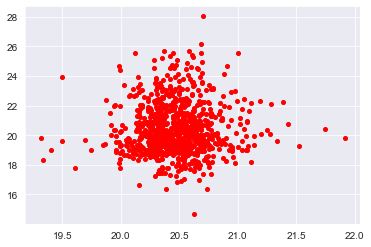

If the prediction was good, we would see a line which is not the case here .


In [40]:
print("Electricity prediction")
plt.plot(y_pred, y_test, "ro", markersize=4)
plt.show()

print("If the prediction was good, we would see a line which is not the case here .")

#### 2) Linear Model : Ridge

In [41]:
n_alphas = 50 #hyperparametre alpha
alphas = np.logspace(-5, 5, n_alphas)

ridge = linear_model.Ridge()

coefs = []
errors = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    errors.append(np.mean((ridge.predict(X_test) - y_test) ** 2))

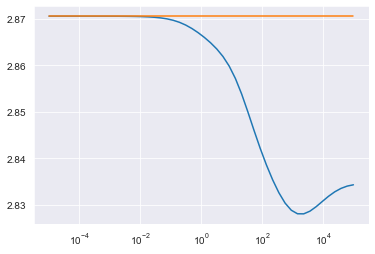

In [42]:
# observation du comportement de l'erreur

ax = plt.gca()
ax.plot(alphas, errors, [10**-5, 10**5], [baseline_error, baseline_error])
ax.set_xscale('log')
plt.show()

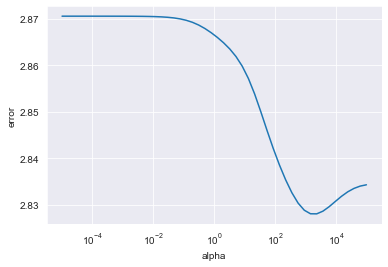

In [43]:
ax = plt.gca()

ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.axis('tight')
plt.show()

In [44]:
# index du min des erreurs
np.argmin(errors)

41

In [45]:
# recupere l'erreur min
errors[np.argmin(errors)]

2.8280417253090797

In [46]:
# recup alpha associé à cet erreur min
alphas[np.argmin(errors)]
# alphas[35]

2329.951810515372

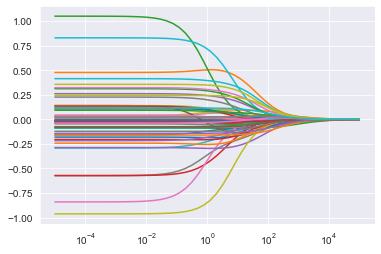

In [47]:
# chemin de régularisation
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.show()

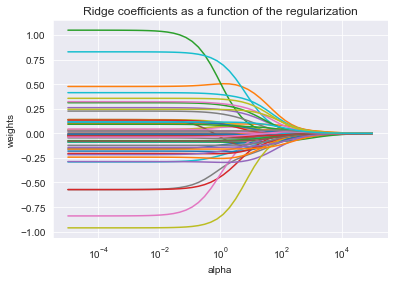

In [48]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

In [49]:
min(errors)

2.8280417253090797

#### 3) Linear Model : LASSO

#### 4) Linear Model : Elastic Net

In [50]:
from sklearn.linear_model import ElasticNet

#rappel de la fonction de coût du elasticnet
#1 / (2 * n_samples) * ||y - Xw||^2_2 + alpha * l1_ratio * ||w||_1 + 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2

parameters = {'tol' : [0.1,0.01,0.001,0.0001],
              "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],  #alpha, coef qui multiplie le terme de pénalité)
              "l1_ratio": np.arange(0.0, 1.0, 0.1)}#L1 ratio , =1 équivaut à un Lasso, 0 à un Ridge


elastic_grid = GridSearchCV(estimator = ElasticNet(),
                            param_grid = parameters,
                            scoring = 'neg_mean_squared_error',
                            cv=5,
                            verbose=0
                            )

elastic_grid.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.561e+03, tolerance: 5.245e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.582e+03, tolerance: 5.288e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'tol': [0.1, 0.01, 0.001, 0.0001]},
             scoring='neg_mean_squared_error')

In [51]:
elastic_grid.best_params_

{'alpha': 1, 'l1_ratio': 0.0, 'tol': 0.1}

In [52]:
results = pd.DataFrame({})

import math
results = results.append(pd.DataFrame({
    'Modèle' : ['Elasticnet Regression'],
    'Score_RMSE' : [math.sqrt(mean_squared_error(elastic_grid.predict(X_test), y_test))]}),
    ignore_index=True)

### 2) Ensemble learning methods

#### 1) Parallelized Implementation : Random Forest

In [53]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=1000) # nb of trees 1000 for the forest

In [54]:
X_train

,NumberofFloors,PropertyGFATotal,PropertyGFAParking,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,YearBuilt,BuildingType_Campus,BuildingType_Multifamily HR (10+),BuildingType_Multifamily LR (1-4),BuildingType_Multifamily MR (5-9),...,Neighborhood_downtown,Neighborhood_east,Neighborhood_greater duwamish,Neighborhood_lake union,Neighborhood_magnolia / queen anne,Neighborhood_north,Neighborhood_northeast,Neighborhood_northwest,Neighborhood_southeast,Neighborhood_southwest
1,-0.499734,-0.462226,-0.252566,-0.141522,0.134019,1928,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.314688,-0.468417,-0.252566,-0.382358,-0.207072,1925,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.905866,-0.106769,-0.252566,-0.382358,-0.207072,1971,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.314688,-0.384912,-0.042709,-0.266691,-0.207072,2001,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-0.129642,-0.365813,-0.252566,-0.382358,-0.207072,1996,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,0.055404,-0.264528,-0.252566,-0.382358,-0.207072,1925,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3125,-0.499734,-0.403766,-0.252566,-0.006164,-0.046558,1927,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3126,-0.314688,-0.344549,0.022846,0.006725,0.871936,2001,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3128,0.055404,-0.404507,-0.073157,-0.141054,-0.039870,2001,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
rfr = rfr.fit(X_train.values, y_train)

In [56]:
from sklearn.metrics import accuracy_score
import timeit

start_time = timeit.default_timer()

pred = rfr.predict(X_test.values)

elapsed = timeit.default_timer() - start_time

accuracy = rfr.score(X_test.values, y_test)

print("accuracy {:.2f} time {:.2f}s".format(accuracy, elapsed))


accuracy -0.10 time 0.25s


In [57]:
from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(rfr, prefit=True, threshold=0.01)
X_train2 = model.transform(X_train.values)
X_train2.shape

(2191, 15)

In [58]:
X_train2

array([[-0.49973446, -0.46222641, -0.25256596, ...,  0.        ,
         0.        ,  0.        ],
       [-0.31468828, -0.46841723, -0.25256596, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.90586576, -0.1067694 , -0.25256596, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.31468828, -0.34454889,  0.02284583, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.05540406, -0.40450719, -0.07315724, ...,  0.        ,
         0.        ,  0.        ],
       [-0.49973446, -0.50255202, -0.25256596, ...,  0.        ,
         0.        ,  0.        ]])

In [59]:
rfr2 = RandomForestRegressor(n_estimators=1000) # nb of trees 1000 for the forest
rfr2 = rfr.fit(X_train2, y_train)


In [60]:
run_experiment(rfr)

"""
R² :  -0.036410020297567236
MAE : 1.3407748367227499
RMSE: 1.698681454232116
"""

R² :  -0.1063675003796849
MAE : 1.384857045047696
RMSE: 1.7696072318255691


'\nR² :  -0.036410020297567236\nMAE : 1.3407748367227499\nRMSE: 1.698681454232116\n'

In [61]:
run_experiment(rfr2)

R² :  -0.10641785322343456
MAE : 1.384402771464533
RMSE: 1.7696475004264651


In [62]:
from sklearn.ensemble import RandomForestRegressor

parameters = {
    'n_estimators' : [10,50,100,300,500], #nombre d'arbres de décision
    'min_samples_leaf' : [1,3,5,10], #nombre de feuilles minimales dans un noeud
    'max_features': ['auto', 'sqrt'] #nombre de features observées pour chaque arbre
}

In [63]:
rfr_search = GridSearchCV(RandomForestRegressor(),
                          param_grid = parameters,
                          #scoring='mean_squared_error',
                          verbose=2,
                          cv=5)

rfr_search.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=100; total time=   1.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=100; total time=   1.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=100; total time=   1.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=100; total time=   1.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=100; total time=   1.2s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=300; total time=   4.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=300; total time=   5.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=300; total time=   5.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=300; total time=   4.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=300; total time=   4.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=500; total time=   6.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=500; total time=   5.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=500; total time=   5.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=500; total time=   5.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=500; total time=   5.8s
[CV] END max_features=auto, min_samples_leaf=3, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=3, n_estimators=10; total time=   0.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestR

[CV] END max_features=auto, min_samples_leaf=3, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=3, n_estimators=10; total time=   0.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=3, n_estimators=50; total time=   0.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=50; total time=   0.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=50; total time=   0.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=50; total time=   0.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=50; total time=   0.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=100; total time=   0.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=100; total time=   0.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=100; total time=   0.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=100; total time=   0.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=100; total time=   0.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=300; total time=   2.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=300; total time=   2.2s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=300; total time=   2.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=300; total time=   2.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=300; total time=   2.2s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=500; total time=   4.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=500; total time=   4.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=500; total time=   4.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=500; total time=   3.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=500; total time=   4.0s
[CV] END max_features=auto, min_samples_leaf=5, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=5, n_estimators=10; total time=   0.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestR

[CV] END max_features=auto, min_samples_leaf=5, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=5, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=5, n_estimators=10; total time=   0.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=50; total time=   0.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=50; total time=   0.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=50; total time=   0.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=50; total time=   0.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=50; total time=   0.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=100; total time=   0.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=100; total time=   0.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=100; total time=   0.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=100; total time=   0.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=100; total time=   0.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=300; total time=   2.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=300; total time=   2.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=300; total time=   2.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=300; total time=   2.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=300; total time=   2.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=500; total time=   3.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=500; total time=   3.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=500; total time=   3.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=500; total time=   4.2s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=500; total time=   3.3s
[CV] END max_features=auto, min_samples_leaf=10, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=10, n_estimators=10; total time=   0.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestR

[CV] END max_features=auto, min_samples_leaf=10, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=10, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=10, n_estimators=10; total time=   0.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestR

[CV] END max_features=auto, min_samples_leaf=10, n_estimators=50; total time=   0.2s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=50; total time=   0.2s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=50; total time=   0.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=50; total time=   0.2s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=50; total time=   0.2s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=100; total time=   0.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=100; total time=   0.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=100; total time=   0.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=100; total time=   0.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=100; total time=   0.5s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=300; total time=   1.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=300; total time=   1.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=300; total time=   1.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=300; total time=   1.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=300; total time=   1.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=500; total time=   3.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=500; total time=   4.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=500; total time=   3.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=500; total time=   3.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_features=auto, min_samples_leaf=10, n_estimators=500; total time=   2.6s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.1s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.1s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.1s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.1s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.1s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=100; total ti

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 3, 5, 10],
                         'n_estimators': [10, 50, 100, 300, 500]},
             verbose=2)

In [64]:
rfr_search.best_params_

{'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 100}

In [65]:
import math
results = results.append(pd.DataFrame({
    'Modèle' : ['Random Forest Regressor'],
    'Score_RMSE' : [math.sqrt(mean_squared_error(rfr_search.predict(X_test), y_test))]}),
    ignore_index=True)

In [66]:
coefficients = abs(rfr_search.best_estimator_.feature_importances_)
liste_coefs_rer = pd.concat((pd.DataFrame(X.columns, columns = ['Variable']),
                             pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)

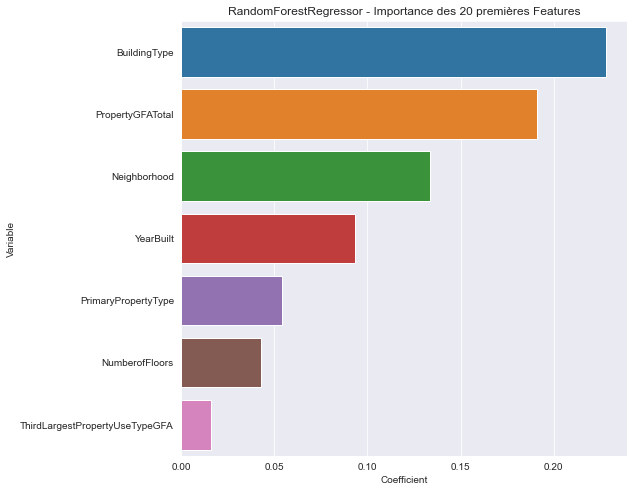

In [67]:
plt.figure(figsize=(8,8))
plt.title('RandomForestRegressor - Importance des 20 premières Features')
sns.barplot(y = liste_coefs_rer['Variable'].head(20),
            x = liste_coefs_rer['Coefficient'].head(20))
plt.show()

#### 2) Sequence Tree : XGBoost

#### 4) Linear Model : Elastic Net

### 2) Ensemble learning methods

#### 1) Parallelized Implementation : Random Forest

In [68]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=1000) # nb of trees 1000 for the forest

In [69]:
X_train

,NumberofFloors,PropertyGFATotal,PropertyGFAParking,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,YearBuilt,BuildingType_Campus,BuildingType_Multifamily HR (10+),BuildingType_Multifamily LR (1-4),BuildingType_Multifamily MR (5-9),...,Neighborhood_downtown,Neighborhood_east,Neighborhood_greater duwamish,Neighborhood_lake union,Neighborhood_magnolia / queen anne,Neighborhood_north,Neighborhood_northeast,Neighborhood_northwest,Neighborhood_southeast,Neighborhood_southwest
1,-0.499734,-0.462226,-0.252566,-0.141522,0.134019,1928,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.314688,-0.468417,-0.252566,-0.382358,-0.207072,1925,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.905866,-0.106769,-0.252566,-0.382358,-0.207072,1971,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.314688,-0.384912,-0.042709,-0.266691,-0.207072,2001,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-0.129642,-0.365813,-0.252566,-0.382358,-0.207072,1996,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,0.055404,-0.264528,-0.252566,-0.382358,-0.207072,1925,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3125,-0.499734,-0.403766,-0.252566,-0.006164,-0.046558,1927,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3126,-0.314688,-0.344549,0.022846,0.006725,0.871936,2001,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3128,0.055404,-0.404507,-0.073157,-0.141054,-0.039870,2001,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
rfr = rfr.fit(X_train.values, y_train)

In [71]:
from sklearn.metrics import accuracy_score
import timeit

start_time = timeit.default_timer()

pred = rfr.predict(X_test.values)

elapsed = timeit.default_timer() - start_time

accuracy = rfr.score(X_test.values, y_test)

print("accuracy {:.2f} time {:.2f}s".format(accuracy, elapsed))


accuracy -0.11 time 0.23s


In [72]:
from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(rfr, prefit=True, threshold=0.01)
X_train2 = model.transform(X_train.values)
X_train2.shape

(2191, 15)

In [73]:
X_train2

array([[-0.49973446, -0.46222641, -0.25256596, ...,  0.        ,
         0.        ,  0.        ],
       [-0.31468828, -0.46841723, -0.25256596, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.90586576, -0.1067694 , -0.25256596, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.31468828, -0.34454889,  0.02284583, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.05540406, -0.40450719, -0.07315724, ...,  0.        ,
         0.        ,  0.        ],
       [-0.49973446, -0.50255202, -0.25256596, ...,  0.        ,
         0.        ,  0.        ]])

In [74]:
rfr2 = RandomForestRegressor(n_estimators=1000) # nb of trees 1000 for the forest
rfr2 = rfr.fit(X_train2, y_train)


In [ ]:
run_experiment(rfr)

"""
R² :  -0.036410020297567236
MAE : 1.3407748367227499
RMSE: 1.698681454232116
"""

In [ ]:
run_experiment(rfr2)

In [ ]:
X_train_tryout = X_train.copy()
X_test_tryout = X_test.copy()

X_train_tryout = X_train_tryout[X_train_tryout.columns[:6]]

X_train_tryout

X_test_tryout = X_test_tryout[X_test_tryout.columns[:6]]

In [ ]:
rfr_try = rfr.fit(X_train_tryout.values, y_train)


In [ ]:

start_time = timeit.default_timer()
pred = rfr_try.predict(X_test_tryout.values)
elapsed = timeit.default_timer() - start_time

accuracy = rfr_try.score(X_test_tryout.values, y_test)
print("accuracy {:.2f} time {:.2f}s".format(accuracy, elapsed))


In [ ]:
run_experiment(rfr_try)

#### 2) Sequence Tree : XGBoost

#### Export des modèles pour réutilisation ultérieure


#### Chargement des modèles


#### Comparaison des modèles


### III) Evaluation

#### Vérification des prédictions


#### Intérêt du Energy Star Score
